# Install required packages

In [103]:
%pip install transformers datasets
%pip install pandas
%pip install matplotlib
%pip install umap-learn
%pip install datashader bokeh holoviews colorcet scikit-image

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import transformers


# Load Data

In [ ]:
from pathlib import Path


DATA_DIR = Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris"
assert DATA_DIR.is_dir()


TypeError: unsupported operand type(s) for /: 'method' and 'str'

In [ ]:
ANP_DIR = DATA_DIR / "ANP" / "CleanFiles_perYear"
assert ANP_DIR.is_dir()


## ANP

In [ ]:
from tqdm import tqdm


FILE_GLOB = "ANP_19[0-9][0-9].csv.gz"
ENCODING = "iso8859_15"


texts = pd.concat(
    tqdm(
        (
            pd.read_csv(
                f, compression="gzip", sep=";", encoding=ENCODING, parse_dates=["date"]
            ).dropna(subset="content")
            for f in ANP_DIR.glob(FILE_GLOB)
        ),
        total=len(list(ANP_DIR.glob(FILE_GLOB))),
        unit="file",
        desc="Reading",
    ),
    ignore_index=True,
).convert_dtypes()


Reading: 100%|██████████| 47/47 [00:15<00:00,  2.99file/s]


In [ ]:
def to_decade(year: int) -> str:
    start = int(year / 10) * 10
    return f"{start} - {start+10}"


texts["decade"] = texts["year"].apply(to_decade)


texts


,filename,content,date,year,month,day,issue,decade
0,anp_1952_01_01_10_ocr.xml,Red.: Datum: veldman 1-1-52 Tijd: 13 ttt^....,1952-01-01,1952,1,1,10,1950 - 1960
1,anp_1952_01_01_11_ocr.xml,Red. Datum: Tijd: Onderwerp: veltmeijer 1...,1952-01-01,1952,1,1,11,1950 - 1960
2,anp_1952_01_01_12_ocr.xml,/3* Red. Datum: Tijd: Onderwerp: veltmei...,1952-01-01,1952,1,1,12,1950 - 1960
3,anp_1952_01_01_13_ocr.xml,Red.: Datum: Tijd: Onderwerp: veltmeijer ...,1952-01-01,1952,1,1,13,1950 - 1960
4,anp_1952_01_01_14_ocr.xml,Red.: Datum: Tijd: Onderwerp: mallon 1-1-...,1952-01-01,1952,1,1,14,1950 - 1960
...,...,...,...,...,...,...,...,...
1472501,anp_1973_12_31_96_ocr.xml,Red.: Datum: Tijd: Onderwerp: kreek 31. 12. 7...,1973-12-31,1973,12,31,96,1970 - 1980
1472502,anp_1973_12_31_97_ocr.xml,Red.: Datum: Tijd: Onderwerp: kuy 31-12-...,1973-12-31,1973,12,31,97,1970 - 1980
1472503,anp_1973_12_31_98_ocr.xml,Red. Datum: Tijd: Onderwerp: kreek 31. 12...,1973-12-31,1973,12,31,98,1970 - 1980
1472504,anp_1973_12_31_99_ocr.xml,Red. Datum: Tijd: Onderwerp: zijl 31-12-...,1973-12-31,1973,12,31,99,1970 - 1980


Text(0, 0.5, 'Number of Documents')

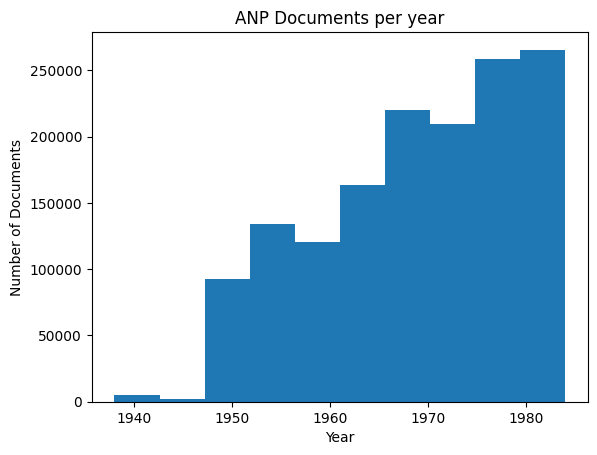

In [ ]:
plt.hist(texts.year, label="Year")
plt.title("ANP Documents per year")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0.5, 0, 'Number of Characters')

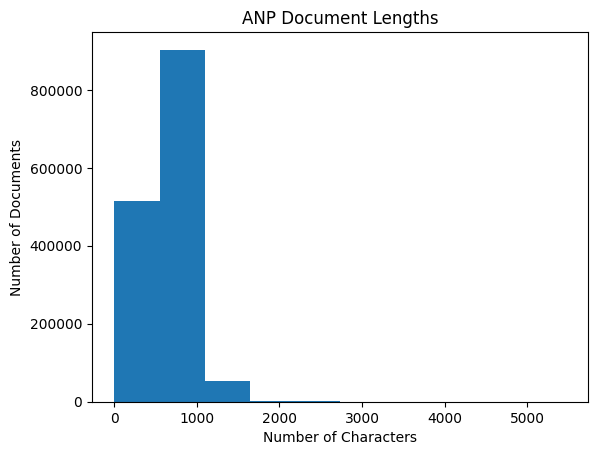

In [ ]:
plt.hist(texts.content.str.len())
plt.title("ANP Document Lengths")
plt.ylabel("Number of Documents")
plt.xlabel("Number of Characters")


# Load Model

In [ ]:
MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"  # NL MODEL TODO: is the model trained on lowercased data?


In [ ]:
from transformers import AutoTokenizer, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline(
    "feature-extraction", model=MODEL_NAME, tokenizer=tokenizer
)


Some weights of the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this mode

# Compute Embeddings

In [ ]:
TERM = "duurzaam"



In [ ]:
term_token_ids = model.tokenizer(TERM)["input_ids"]
print(term_token_ids)

print(model.tokenizer.convert_ids_to_tokens(term_token_ids))


[0, 6395, 8262, 2]
['<s>', 'duur', 'zaamheid', '</s>']


In [ ]:
texts[TERM] = texts.content.str.contains(TERM)


In [ ]:
texts.loc[texts[TERM]]


,filename,content,date,year,month,day,issue,decade,duurzaamheid
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,1976-07-01,1976,1,7,39,1970 - 1980,True
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,1968-02-22,1968,2,22,59,1960 - 1970,True
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,1950-03-09,1950,9,3,61,1950 - 1960,True
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983-10-02,1983,2,10,117,1980 - 1990,True
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983-10-02,1983,2,10,53,1980 - 1990,True
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,1983-07-13,1983,7,13,128,1980 - 1990,True
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,1983-07-13,1983,7,13,3,1980 - 1990,True
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,1970-12-19,1970,12,19,65,1970 - 1980,True
564721,anp_1972_02_23_101_ocr.xml,Red. Datu m: Tijd: Onderwerp: jansen 23...,1972-02-23,1972,2,23,101,1970 - 1980,True
594448,anp_1972_10_09_90_ocr.xml,Red.: Datum: Tijd: Onderwerp: cas 9-10-7...,1972-09-10,1972,10,9,90,1970 - 1980,True


Text(0, 0.5, 'Number of Documents')

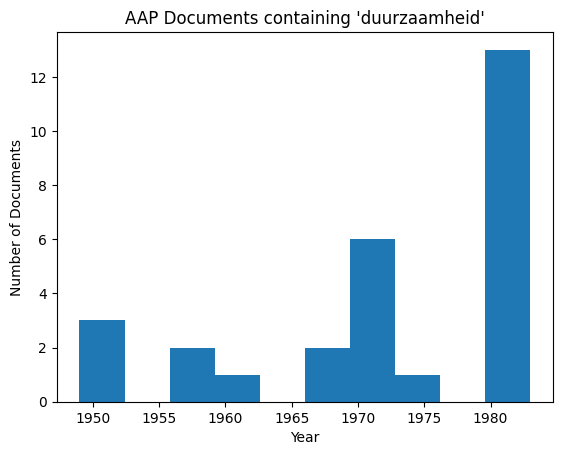

In [ ]:
plt.hist(texts.loc[texts.content.str.contains(TERM)].year)
plt.title(f"AAP Documents containing '{TERM}'")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


In [ ]:
import importlib
import src

importlib.reload(src)

from src import Sentence

texts.loc[texts[TERM], "Sentence"] = texts.loc[texts[TERM]].apply(
    lambda row: Sentence(row["content"], model, row["year"], row["filename"]),
    axis=1,
)

texts


,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence
0,anp_1952_01_01_10_ocr.xml,Red.: Datum: veldman 1-1-52 Tijd: 13 ttt^....,1952-01-01,1952,1,1,10,1950 - 1960,False,NaN
1,anp_1952_01_01_11_ocr.xml,Red. Datum: Tijd: Onderwerp: veltmeijer 1...,1952-01-01,1952,1,1,11,1950 - 1960,False,NaN
2,anp_1952_01_01_12_ocr.xml,/3* Red. Datum: Tijd: Onderwerp: veltmei...,1952-01-01,1952,1,1,12,1950 - 1960,False,NaN
3,anp_1952_01_01_13_ocr.xml,Red.: Datum: Tijd: Onderwerp: veltmeijer ...,1952-01-01,1952,1,1,13,1950 - 1960,False,NaN
4,anp_1952_01_01_14_ocr.xml,Red.: Datum: Tijd: Onderwerp: mallon 1-1-...,1952-01-01,1952,1,1,14,1950 - 1960,False,NaN
...,...,...,...,...,...,...,...,...,...,...
1472501,anp_1973_12_31_96_ocr.xml,Red.: Datum: Tijd: Onderwerp: kreek 31. 12. 7...,1973-12-31,1973,12,31,96,1970 - 1980,False,NaN
1472502,anp_1973_12_31_97_ocr.xml,Red.: Datum: Tijd: Onderwerp: kuy 31-12-...,1973-12-31,1973,12,31,97,1970 - 1980,False,NaN
1472503,anp_1973_12_31_98_ocr.xml,Red. Datum: Tijd: Onderwerp: kreek 31. 12...,1973-12-31,1973,12,31,98,1970 - 1980,False,NaN
1472504,anp_1973_12_31_99_ocr.xml,Red. Datum: Tijd: Onderwerp: zijl 31-12-...,1973-12-31,1973,12,31,99,1970 - 1980,False,NaN


In [ ]:
texts.loc[texts["Sentence"].notna()]

,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,1976-07-01,1976,1,7,39,1970 - 1980,True,Sentence(text=' Red.: cas Datum: 7-1-76 Tijd...
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,1968-02-22,1968,2,22,59,1960 - 1970,True,Sentence(text=' Red.: Datu m: Tijd: Onderw...
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,1950-03-09,1950,9,3,61,1950 - 1960,True,"Sentence(text="" Cremers zondagweekoverzicht 3...."
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983-10-02,1983,2,10,117,1980 - 1990,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983-10-02,1983,2,10,53,1980 - 1990,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,1983-07-13,1983,7,13,128,1980 - 1990,True,Sentence(text=' Red.: Datum: Tijd: Onderwerp: ...
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,1983-07-13,1983,7,13,3,1980 - 1990,True,"Sentence(text="" Red.: spa 13 ? 83 Tijd: On..."
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,1970-12-19,1970,12,19,65,1970 - 1980,True,"Sentence(text="" Red. Datum: Tijd: Onderwerp..."
564721,anp_1972_02_23_101_ocr.xml,Red. Datu m: Tijd: Onderwerp: jansen 23...,1972-02-23,1972,2,23,101,1970 - 1980,True,Sentence(text=' Red. Datu m: Tijd: Onderwe...
594448,anp_1972_10_09_90_ocr.xml,Red.: Datum: Tijd: Onderwerp: cas 9-10-7...,1972-09-10,1972,10,9,90,1970 - 1980,True,Sentence(text=' Red.: Datum: Tijd: Onderwer...


In [ ]:
texts["embeddings"] = texts.loc[texts["Sentence"].notna()]["Sentence"].apply(
    lambda s: s.embeddings_matrix(TERM)
)
texts.loc[texts["embeddings"].notna()]


,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence,embeddings
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,1976-07-01,1976,1,7,39,1970 - 1980,True,Sentence(text=' Red.: cas Datum: 7-1-76 Tijd...,"[[0.025340180844068527, 0.0973568931221962, 0...."
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,1968-02-22,1968,2,22,59,1960 - 1970,True,Sentence(text=' Red.: Datu m: Tijd: Onderw...,"[[-0.27710914611816406, 0.28737807273864746, -..."
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,1950-03-09,1950,9,3,61,1950 - 1960,True,"Sentence(text="" Cremers zondagweekoverzicht 3....","[[0.32683679461479187, 0.2526993751525879, -0...."
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983-10-02,1983,2,10,117,1980 - 1990,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...,"[[0.10254843533039093, -0.04931650310754776, -..."
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983-10-02,1983,2,10,53,1980 - 1990,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...,"[[0.5021758079528809, 0.12269017100334167, -0...."
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,1983-07-13,1983,7,13,128,1980 - 1990,True,Sentence(text=' Red.: Datum: Tijd: Onderwerp: ...,"[[0.30946338176727295, 0.1836877465248108, -0...."
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,1983-07-13,1983,7,13,3,1980 - 1990,True,"Sentence(text="" Red.: spa 13 ? 83 Tijd: On...","[[0.18053409457206726, -0.0619555339217186, -0..."
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,1970-12-19,1970,12,19,65,1970 - 1980,True,"Sentence(text="" Red. Datum: Tijd: Onderwerp...","[[-0.3447812497615814, 0.12266619503498077, -0..."
564721,anp_1972_02_23_101_ocr.xml,Red. Datu m: Tijd: Onderwerp: jansen 23...,1972-02-23,1972,2,23,101,1970 - 1980,True,Sentence(text=' Red. Datu m: Tijd: Onderwe...,"[[-0.5472287535667419, 0.6872007250785828, 0.1..."
594448,anp_1972_10_09_90_ocr.xml,Red.: Datum: Tijd: Onderwerp: cas 9-10-7...,1972-09-10,1972,10,9,90,1970 - 1980,True,Sentence(text=' Red.: Datum: Tijd: Onderwer...,"[[-0.08458370715379715, 0.14093522727489471, -..."


In [ ]:
# Candidate sentences with no actual matches for the term

texts.loc[texts["embeddings"].str.len() == 0]


,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence,embeddings


In [ ]:
indices = []
embeddings = []

for row in texts.loc[texts.Sentence.notna()].itertuples():
    for embedding in row.Sentence.embeddings_matrix(TERM):
        indices.append(row.Index)
        embeddings.append(embedding)


In [ ]:
embeddings = np.array(embeddings)

assert embeddings.shape[1] == model.model.config.hidden_size

embeddings.shape

(33, 768)

# Plot

In [ ]:
import umap.plot

umap.plot.output_notebook()

title = f"UMAP Embeddings Projections for '{TERM}'"

Loading BokehJS ...

In [ ]:
mapper = umap.UMAP().fit(embeddings)


In [ ]:
texts.loc[indices, "x"] = mapper.embedding_[:, 0]
texts.loc[indices, "y"] = mapper.embedding_[:, 1]
texts.loc[indices]


,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence,embeddings,x,y
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,1976-07-01,1976,1,7,39,1970 - 1980,True,Sentence(text=' Red.: cas Datum: 7-1-76 Tijd...,"[[0.025340180844068527, 0.0973568931221962, 0....",19.297659,-1.188498
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,1968-02-22,1968,2,22,59,1960 - 1970,True,Sentence(text=' Red.: Datu m: Tijd: Onderw...,"[[-0.27710914611816406, 0.28737807273864746, -...",19.836714,-1.577619
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,1950-03-09,1950,9,3,61,1950 - 1960,True,"Sentence(text="" Cremers zondagweekoverzicht 3....","[[0.32683679461479187, 0.2526993751525879, -0....",19.665432,0.732918
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983-10-02,1983,2,10,117,1980 - 1990,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...,"[[0.10254843533039093, -0.04931650310754776, -...",17.087240,1.343898
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983-10-02,1983,2,10,117,1980 - 1990,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...,"[[0.10254843533039093, -0.04931650310754776, -...",17.087240,1.343898
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983-10-02,1983,2,10,53,1980 - 1990,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...,"[[0.5021758079528809, 0.12269017100334167, -0....",17.424051,1.020373
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983-10-02,1983,2,10,53,1980 - 1990,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...,"[[0.5021758079528809, 0.12269017100334167, -0....",17.424051,1.020373
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,1983-07-13,1983,7,13,128,1980 - 1990,True,Sentence(text=' Red.: Datum: Tijd: Onderwerp: ...,"[[0.30946338176727295, 0.1836877465248108, -0....",18.808577,-0.339250
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,1983-07-13,1983,7,13,3,1980 - 1990,True,"Sentence(text="" Red.: spa 13 ? 83 Tijd: On...","[[0.18053409457206726, -0.0619555339217186, -0...",19.164776,-0.653173
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,1970-12-19,1970,12,19,65,1970 - 1980,True,"Sentence(text="" Red. Datum: Tijd: Onderwerp...","[[-0.3447812497615814, 0.12266619503498077, -0...",18.373228,0.678502


## Static

Text(0.5, 1.0, "UMAP Embeddings Projections for 'duurzaamheid'")

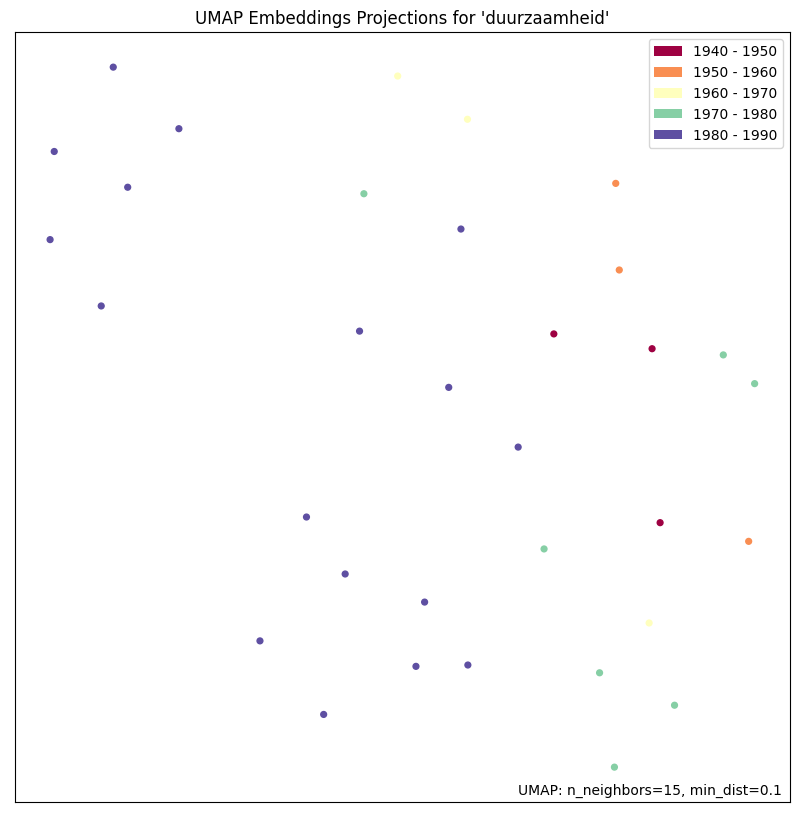

In [ ]:
subplot = umap.plot.points(mapper, height=1000, width=1000, labels=texts.loc[indices]["decade"])
subplot.set_title(title)


## Interactive

In [ ]:
from bokeh.models import ColumnDataSource

df = texts.loc[indices][["content", "year", "filename", "decade", "x", "y"]]
source = ColumnDataSource(data=df)
df


,content,year,filename,decade,x,y
28957,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,1976,anp_1976_01_07_39_ocr.xml,1970 - 1980,19.297659,-1.188498
83532,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,1968,anp_1968_02_22_59_ocr.xml,1960 - 1970,19.836714,-1.577619
171251,Cremers zondagweekoverzicht 3. 9*50 Het bese...,1950,anp_1950_09_03_61_ocr.xml,1950 - 1960,19.665432,0.732918
338005,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983,anp_1983_02_10_117_ocr.xml,1980 - 1990,17.087240,1.343898
338005,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983,anp_1983_02_10_117_ocr.xml,1980 - 1990,17.087240,1.343898
338103,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983,anp_1983_02_10_53_ocr.xml,1980 - 1990,17.424051,1.020373
338103,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983,anp_1983_02_10_53_ocr.xml,1980 - 1990,17.424051,1.020373
363292,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,1983,anp_1983_07_13_128_ocr.xml,1980 - 1990,18.808577,-0.339250
363338,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,1983,anp_1983_07_13_3_ocr.xml,1980 - 1990,19.164776,-0.653173
435255,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,1970,anp_1970_12_19_65_ocr.xml,1970 - 1980,18.373228,0.678502


In [ ]:
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
import bokeh.palettes

categories = texts.decade.unique()
palette = bokeh.palettes.Category20[len(categories)]

assert len(palette) >= len(
    categories
), f"Palette has only {len(palette)} categories, but {len(categories)} needed."

color_mapper = CategoricalColorMapper(
    factors=[str(c) for c in categories], palette=palette
)
color_mapper


CategoricalColorMapper(id='1232', ...)

In [ ]:
from bokeh.models.tickers import SingleIntervalTicker
from bokeh.plotting import figure, show

p = figure(
    height=1000,
    width=1000,
    tooltips=[("filename", "@filename"), ("content", "@content"), ("year", "@year")],
)
p.title = title

# TODO: group by decade to enable muting decades individually via legend
p.dot(
    x="x",
    y="y",
    legend_field="decade",
    source=source,
    size=20,
    color={"field": "decade", "transform": color_mapper},
)

p.legend.click_policy = "mute"

p.xaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)
p.yaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)

# FIXME: empty ploy
show(p)
